In [2]:
import numpy as np
import matplotlib.pyplot as plt

For the first simple example, consider the steady flow in a channel between two parallel plates; the Poseuille flow. As the flow is steady and unifrom in the x-direction, the system is described by the simple boundary value problem

$$
\mathcal{F} = f_x + \nu\frac{d^2u}{dy^2} = 0 \tag{3.18}
$$

$$
\mathcal{B} = u(0) = u(L) = 0 \tag{3.19}
$$

where $f_x$ is the applied horizontal body force, $u = u(y)$ is the velocity component, $\nu$ is the kinematic viscosity and $L$ is the width of the channel. Equation 3.18 is the conservation of x-momentum and equation 3.19 are the no-slip boundary conditions on the walls at $y = 0$ and $y=L$. The solution of this second order differential equation is simply

$$
u = \frac{f_x}{2\nu}y(L-y)
$$

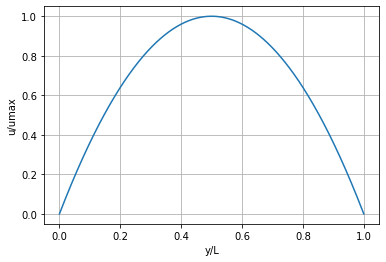

In [3]:
L = 1
Ny = 1000
dy = L/Ny
y = np.linspace(0, L, Ny)
v = 1
fx = 1
u_analytical = (fx/(2*v)) * (y*(L-y))
u_max = (fx*L**2)/(8*v)
plt.plot(y/L, u_analytical/u_max)
plt.xlabel("y/L")
plt.ylabel("u/umax")
plt.grid(which="both")

The equation

$$
\mathcal{M}\left(\overrightarrow{x}\right) = \left[1-\delta_\epsilon\left(\overrightarrow{x}\right)\right]\mathcal{F}\left(\overrightarrow{x}\right) + \frac{1}{c}\delta_\epsilon\left(\overrightarrow{x}\right)\mathcal{B}\left(\overrightarrow{x}\right) = 0
$$

is applied to this boundary value problem, resulting in the meta-equation

$$
\left\{\frac{1}{c}\delta_\epsilon(y)-\left[1-\delta_\epsilon(y)\right]\frac{d^2}{dy^2}\right\}u_\epsilon = \left[1-\delta_\epsilon(y)\right]\frac{f_x}{\nu} + \frac{1}{c}\delta_\epsilon(y)U
$$

The second derivative is required, and is estimated using the 1D second order difference matrix $D^2$ with components

In [4]:
def second_order_difference_matrix(N):
    """
    Creates a second difference matrix for a line segment N long
    """
    D = np.zeros((N,N))
    np.fill_diagonal(D, -2)
    #D[0,0] = 1
    #D[-1,-1] = 1
    np.fill_diagonal(D[1:], 1)
    np.fill_diagonal(D[:,1:], 1)
    return D

D = second_order_difference_matrix(Ny)
print(D)

[[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -2.]]


Setting $c=\Delta y$ to balance the soid and fluid inflience and setting $\epsilon = 0$ results in the linear algebra system

$$
$$

for $\mathbf{u}$. The solution of 3.23 is the exact solution at every point in the fluid domain. Additionally, the exact soltion (zero) is achieved outside the fluid domain. Thus consistency is esablished.

(0.0, 1.0)

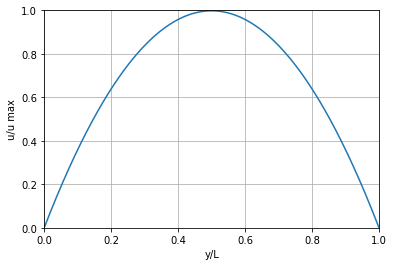

In [5]:
delta = np.zeros(Ny)
delta[0] = 1
delta[-1] = 1
A1 = np.einsum('i,ij->ij', (1-delta), D)
A2 = np.zeros_like(A1)
np.fill_diagonal(A2, delta)
A2
A = A2+A1
A = -1*(1/dy**2)*A
B = np.vstack(1-delta)*(fx/v)
u = np.linalg.solve(A, B)
plt.plot(y/L, u/u_max)
plt.xlabel("y/L")
plt.ylabel("u/u max")
plt.grid(which="both")
plt.xlim((0,1))
plt.ylim(0,1)

The above example used a boundary-fitted grid but equation 3.21 can just as easily be posed on a background grid whose topography does not match the solid body of the boundaries. The only change to the above system is to use the smoothed form of the interpolation function $\delta_\epsilon$ given by equation 3.13 where the distance function is given by:

$$
d(y) = \frac{L}{2} - \left|\frac{L}{2} - y\right|
$$

for this geometry

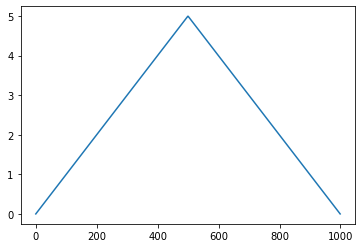

In [21]:
d = L/2 - np.abs(L/2-y)
plt.plot(d/0.1)

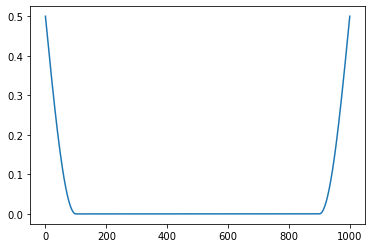

In [30]:
def smoothing_kernel(d, e):
    delta = np.zeros_like(d)
    delta[abs(d)/e <  1] = 0.5 * (1 + np.sin((-np.pi/2)*(d[abs(d)/e < 1]/e)))
    delta[d/e < -1] = 1
    return delta

delta = smoothing_kernel(d, 0.1)
plt.plot(delta)

(0.0, 1.0)

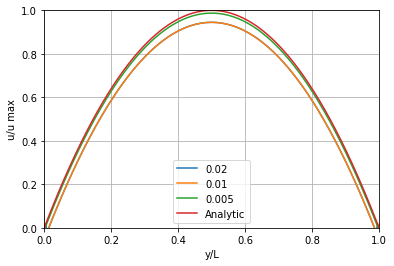

In [31]:
from sklearn.metrics import mean_squared_error

def smoothing_kernel(d, e):
    delta = np.zeros_like(d)
    delta[abs(d)/e <  1] = 0.5 * (1 + np.sin((-np.pi/2)*(d[abs(d)/e < 1]/e)))
    delta[d/e < -1] = 1
    return delta

ratios = [0.02, 0.01, 0.005]
MSE = []

for r in ratios:
    e = L*r
    delta = smoothing_kernel(d, e)
    A1 = np.einsum('i,ij->ij', (1-delta), D)
    A2 = np.zeros_like(A1)
    np.fill_diagonal(A2, delta)
    A2
    A = A2+A1
    A = -1*(1/dy**2)*A
    B = np.vstack(1-delta)*(fx/v)
    u = np.linalg.solve(A, B)
    plt.plot(y/L, u/u_max, label=r)
    E = u.T - u_analytical
    MSE.append(E)
plt.plot(y/L, u_analytical/u_max, label="Analytic")
plt.xlabel("y/L")
plt.ylabel("u/u max")
plt.legend()
plt.grid(which="both")
plt.xlim((0,1))
plt.ylim(0,1)